# Lecture 2 on Variational Quantum Algorithm
<br>
<br>

This notebook presentation is part of my lecture material for the Advanced Quantum Mechanics course at the University of Trieste. It contains a general introduction to variational quantum circuits.

**Michele Grossi**, Senior Researcher @ CERN \

michele.grossi@cern.ch

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

## Variational Quantum Algorithms

Variational Quantum Algorithms (VQA) are hybrid algorithm that use a classical optimizer to train a parameterized quantum circuit to approximate solutions for a given problem. You will find this family of architectures for a lot of application in different fields like: Chemistry, Physics, Finance, Machine Learning and more.

VQA typically need fewer gates and qubits. In turn, they are more resistant to noise and are well suited to handle near-term quantum computer constraints.

VQA's are typically iterative. Each iteration involves both quantum and classical processing. 

Output (a measurement) from one iteration is sent to the classical optimizer which generates input (a parameter) for the next iteration:

<div>
<img src="images/qva_loop.png" width="600" align="left"/>
</div>

## VQE - Application to Physics to study static properties

The Variational Quantum Eigensolver (VQE) is a central algorithm in many applications, e.g. quantum chemistry or optimization.
This tutorial shows you how to run the VQE. We'll start off by defining the algorithm settings, such as the Hamiltonian and ansatz, and then run a VQE both locally, on your machine, and remotely, using the IBM platform.

**Note:** You can find tutorials on solving more comprehensive problems, such as finding the ground state of the lithium hydride molecule, using the VQE within [the tutorials of Qiskit Nature](https://github.com/Qiskit/qiskit-nature/tree/main/docs/tutorials).

## System Hamiltonian

Let's start by defining the operator of which we want to determine the ground state. Here we'll chose a simple diagonal Hamiltonian $\hat H$ acting with Pauli-Z operators on the first two qubits

$$
\hat H = \hat Z_0 \otimes \hat Z_1.
$$

We can construct this Hamiltonian with Qiskit's `opflow` module

In [2]:
from qiskit.opflow import Z, I

num_qubits = 4
hamiltonian = (Z ^ Z) ^ (I ^ (num_qubits - 2))

/var/folders/sm/1d0rxbz57bx0_9fjrdq9bf9m0000gn/T/ipykernel_28005/2599452337.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import Z, I


In [3]:
hamiltonian

PauliOp(Pauli('ZZII'), coeff=1.0)

This Hamiltonian has a ground state energy of -1.

In [4]:
target_energy = -1

## Parameterized Ansatz Circuit

Next, we choose a parameterized quantum circuit $\hat U(\theta)$ to prepare the ansatz wavefunction

$$
|\psi(\theta)\rangle = \hat U(\theta)|0\rangle.
$$

We'll use the `EfficientSU2` circuit from Qiskit's circuit library, which is a hardware efficient, heuristic ansatz with alternating rotation and entanglement layers.

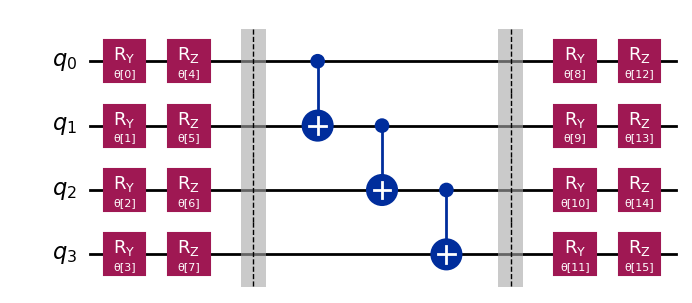

In [5]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

## Solve with the VQE

Now that we have the problem and ansatz specified we can use the Variational Quantum Eigensolver (VQE) to solve for the minimal eigenvalue of our Hamiltonian.

The VQE requires a classical optimization routine, along with an initial point, to calculate the parameter updates.

In [6]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

/var/folders/sm/1d0rxbz57bx0_9fjrdq9bf9m0000gn/T/ipykernel_28005/2721813274.py:2: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA


To access intermediate information we can pass a callback into the VQE. The callback is given the current number of function evaluations, the current parameters, function values and standard deviation in the expectation evaluation. 

In [7]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

### Local VQE

Let's first simulate this system locally using Qiskit's `VQE` class.

In [8]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

/var/folders/sm/1d0rxbz57bx0_9fjrdq9bf9m0000gn/T/ipykernel_28005/2636151075.py:4: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  local_vqe = VQE(ansatz=ansatz,


In [9]:
local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)

In [10]:
print('Eigenvalue:', local_result.eigenvalue)
print('Target:', target_energy)

Eigenvalue: (-1+0j)
Target: -1


With the information from the callback, we can for instance compute the average of the estimation errors in the expectation evaluations. For an exact (statevector) simulation this would be 0, but for a shot-based readout as we have on real hardware, this will be a small finite error.

In [11]:
print('Mean error:', np.mean(intermediate_info['stddev']))

Mean error: 0.016749585279732946


In [12]:
intermediate_info['parameters'][-1]

array([ 1.51486932e+00,  3.25814138e-01,  1.57906948e+00,  5.72407034e-01,
        1.01416683e-01, -2.33455560e+00, -5.40533947e-04,  1.89107774e-01,
        1.62741641e+00,  1.75333279e+00, -1.57249456e+00,  1.57812530e+00,
       -1.96153223e+00,  1.39230585e+00,  8.75326864e-01, -1.67493331e-02])

## Quantum Ising Chain
The system under consideration is the Quantum Ising model with traverse field and fixed parameters and we impose periodic boundary conditions. In the Hamiltonian, $$J>0$$ parametrizes the antiferromagnetic coupling and sets the energy scale, $$h$$ parametrizes the transverse magnetic field.
See https://www.mdpi.com/2073-8994/14/5/996 for additional details.

More specifically, the chain size is fixed to N = 4 (5) and the Hamiltonian H is:


$$
\mathcal{H} = -  J \sum_{i,j}^N \hat{s}_{x}^{(i)}\hat{s}_{x}^{(i+1)} + h \sum_{i}^N \hat{s}_{z}^{(i)}
$$

for $h = J = 1$, and where $\hat{s}_{x}$ and $\hat{s}_{z}$ are the respective Pauli operators applied to the i-th qubit.

In [13]:
from qiskit_ibm_provider import IBMProvider

In [14]:
provider = IBMProvider()
provider

<IBMProvider>

In [15]:
provider.backends()

[<IBMBackend('simulator_stabilizer')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibmq_kolkata')>,
 <IBMBackend('ibm_algiers')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('ibm_cairo')>,
 <IBMBackend('ibmq_mumbai')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_brisbane')>]

### Classical energy levels calculation
The Ising model is a mathematical model of ferromagnetism in statistical mechanics.
The model consists of discrete variables that represent magnetic dipole moments of atomic spins that can be in one of two states ($+1$ or $−1$).
The spins are arranged in a graph, usually a lattice (where the local structure repeats periodically in all directions), allowing each spin to interact with its neighbors.
Neighboring spins that agree have a lower energy than those that disagree; the system tends to the lowest energy but heat disturbs this tendency, thus creating the possibility of different structural phases. 


Consider a set $\Lambda$ of lattice sites, each with a set of adjacent sites (e.g. a graph) forming a $d$-dimensional lattice.For each lattice site $k \in \Lambda$ there is a discrete variable $\sigma_k$ such that $\sigma_k \in \{+1,-1\}$, representing the site's spin. A spin configuration,$(\sigma_k)_{k \in K} \in \{-1,+1\}^K$ is an assignment of spin value to each lattice site.

For any two adjacent sites $i,j \in \Lambda$ there is an interaction $J_{ij}$. Also a site $j \in \Lambda$ has an external magnetic field hj interacting with it. The energy of a configuration $\sigma$ is given by the Hamiltonian function

\begin{equation}
H(\sigma )=\sum _{\langle i~j\rangle }J_{ij}\sigma _{i}\sigma _{j}+\mu \sum _{j}h_{j}\sigma _{j}
\end{equation}

where the first sum is over pairs of adjacent spins (every pair is counted once). The notation $\langle ij \rangle$ indicates that sites $i$ and $j$ are nearest neighbors. The magnetic moment is given by $\mu$.
Ising models can be classified according to the sign of the interaction: if, for a pair i, j

- ${J_{ij}<0}$, the interaction is called ferromagnetic,
- ${J_{ij}>0}$, the interaction is called antiferromagnetic,
- ${J_{ij}=0}$, the spins are noninteracting.

Now we restrict our analisys in the following way

- Quantum case: $\sigma_i$ are Pauli matrices, precisely $\sigma^z _i$ in the first term and $\sigma^x _i$ in the second term;
- Ferromagnetic Model:${J_{ij}<0}$;
- One dimensional chain: $\Lambda$ is 1d lattice;
- Same interaction: $J_{i,j}=J$;
- Same magnetic interaction: $h_j=h$.

The hamiltonian is given by
\begin{equation}
    H=J\sum_{i }\sigma^x_i\sigma^x_{i+1}+b\sum_j\sigma^z_j
\end{equation}
where $b$ now measures the effect of a external magnetic field on the lattice.





In [32]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(H)
#aux_operators=[M]

In [33]:
sol.eigenvalue

-3.450040083574338

### Exercise: Quantum ground state calculation

Now we want to calculate the ground state using quantum circuits, we are going to implement VQE algorithms based on our hamiltonian and noise models.  
We split the computation in three different parts:
- Noiseless;

- Noisy, in this case we consider two different model:
    - Custom noise;
    - Hardware noise;
    
- Mitigated.

In [19]:
import numpy as np 
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Estimator
from qiskit.circuit.library import EfficientSU2, RealAmplitudes
import qiskit_algorithms
from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.quantum_info import Pauli, SparsePauliOp

In [20]:
#hamiltonian generation (for N=5,6)
# number of qubits = i+1+(N-i-1)=N qubits
# see https://qiskit.org/documentation/migration_guides/opflow_migration.html#qubit-paulis

def ham_generator(N, h, J):
    l = [] #we'll add the terms (term,coef)
    # field term
    for i in range(N):
        t = "I"*i + "Z" + "I"*(N-1-i)
        l.append( (t,h) )
    # interaction term
    for k in range(N - 1):
        t = "I"*k + "XX" + "I"*(N-2-k)
        l.append( (t,J) )
    # PBC
    t = "X" + "I"*(N-2) + "X"
    l.append( (t,J) )
    H = SparsePauliOp.from_list(l)
    return H

In [21]:
# Let's define a typical observable: magnetization
def magnetization(N):
    l=[]
    coef=1/N
    # field term
    for i in range(N):
        t = "I"*i + "X" + "I"*(N-1-i)
        l.append( (t,coef) )
    M = SparsePauliOp.from_list(l)
    return M

In [22]:
nqubits=5 #6
h = 0.2 #or -0.2 or 0
J=1


H = ham_generator(nqubits, h, J)
M = magnetization(nqubits)
H, M

(SparsePauliOp(['ZIIII', 'IZIII', 'IIZII', 'IIIZI', 'IIIIZ', 'XXIII', 'IXXII', 'IIXXI', 'IIIXX', 'XIIIX'],
               coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 1. +0.j, 1. +0.j, 1. +0.j,
  1. +0.j, 1. +0.j]),
 SparsePauliOp(['XIIII', 'IXIII', 'IIXII', 'IIIXI', 'IIIIX'],
               coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j]))

In [24]:
##Let's instantiate the service and the cloud simulator
service = QiskitRuntimeService(channel='ibm_quantum')
sim = "ibmq_qasm_simulator"

In [25]:
## Let's define the optimize
optimizer = SPSA(maxiter=15)

In [26]:
## Let's define the ansatz function - the initial weight/parameters
ansatz = RealAmplitudes(num_qubits=nqubits, reps=3)
#ansatz = EfficientSU2(nqubits, reps=3, entanglement='linear', insert_barriers=False)

np.random.seed(6)
initial_point = np.random.random(ansatz.num_parameters)

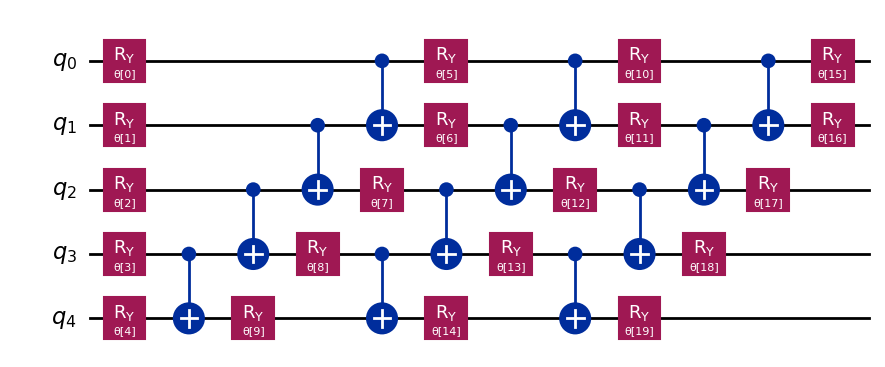

In [27]:
ansatz.decompose().draw('mpl', style='iqx')

In [28]:
# Create an object to store intermediate results
from dataclasses import dataclass

@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count} of ~400", end="\r", flush=True)

log = VQELog([], [])

In [29]:
# Set options to include the noise model
options = Options()

# Set number of shots, optimization_level and resilience_level
options.execution.shots = 1000
options.optimization_level = 3
options.resilience_level = 0

In [30]:
##NOISELESS CASE RUN

with Session(service=service, backend=sim) as session:
    estimator=Estimator(session=session, options=options)
    vqe = VQE(estimator=estimator,
              ansatz=ansatz, 
              optimizer=optimizer, 
              callback=log.update, 
              initial_point=initial_point)
    M = magnetization(nqubits)
    H = ham_generator(nqubits, h, J)
    result = vqe.compute_minimum_eigenvalue(H, aux_operators=[M])

    print("Experiment complete.".ljust(30))
    print(f"GS: {result.optimal_value}")
    print(f"Magn:{result.aux_operators_evaluated}")
    session.close()

Experiment complete.          
GS: -1.7844
Magn:[(-0.007199999999999984, {'variance': 0.10865376000000002, 'shots': 1000, 'warning': 'Optimization level clipped from 3 to 1'})]


In [34]:
result.eigenvalue

-1.7844

In [41]:
fake_backend.operations

[Instruction(name='id', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='rz', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='x', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='reset', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='measure', num_qubits=1, num_clbits=1, params=[]),
 Delay(duration=t[unit=dt])]

In [45]:
## NOISY CASE

from qiskit.providers.fake_provider import FakeAuckland
from qiskit_aer.noise import NoiseModel
# Make a noise model

fake_backend = FakeAuckland()

noise_model = NoiseModel.from_backend(fake_backend)

basis_gates=fake_backend.operations
coupling_map=fake_backend.coupling_map


options.simulator = {
    "noise_model": noise_model,
    "basis_gates":basis_gates,
    "coupling_map": coupling_map,
    "seed_simulator": 42
}

In [46]:
##noisy case
with Session(service=service, backend=sim) as session:
    estimator=Estimator(session=session, options=options)
    vqe = VQE(estimator=estimator,
              ansatz=ansatz, 
              optimizer=optimizer, 
              callback=log.update, 
              initial_point=initial_point)
    M = magnetization(nqubits)
    H = ham_generator(nqubits, h, J)
    result = vqe.compute_minimum_eigenvalue(H, aux_operators=[M])

    print("Experiment complete.".ljust(30))
    print(f"GS: {result.optimal_value}")
    print(f"Magn:{result.aux_operators_evaluated}")
    session.close()

AlgorithmError: 'The primitive job to evaluate the energy failed!'

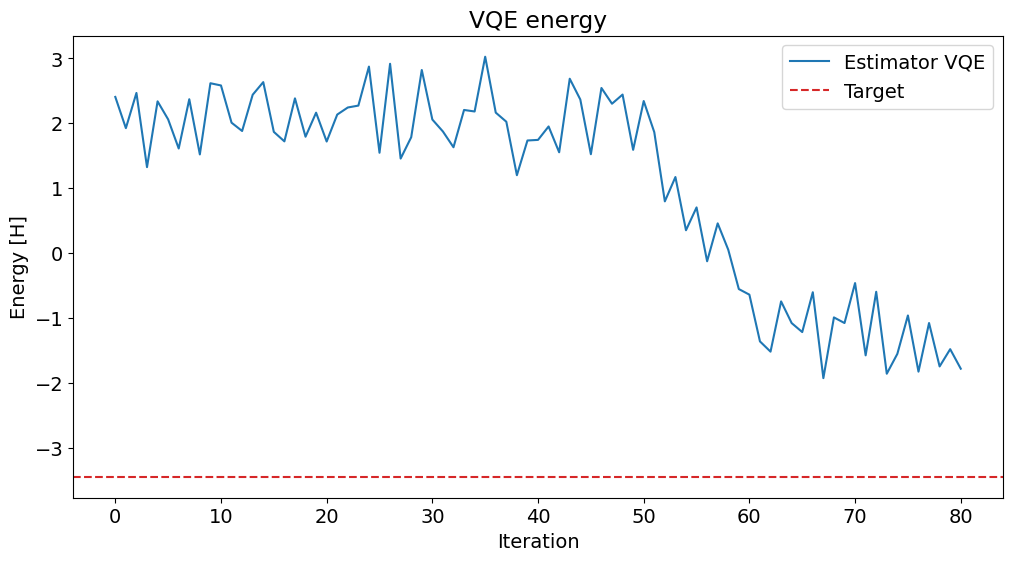

In [47]:
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 14

# Plot energy and reference value
plt.figure(figsize=(12, 6))
plt.plot(log.values, label="Estimator VQE")
plt.axhline(y=sol.eigenvalue, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()